In [1]:
import time 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pinocchio as pin
from scipy.optimize import least_squares
from scipy.special import huber
from projectyl.utils.properties import ELBOW, SHOULDER, WRIST
from projectyl.utils.arm import plot_optimization_curves

from projectyl.dynamics.inverse_kinematics import build_arm_model
from projectyl.utils.arm import interactive_replay_sequence
from projectyl.utils.io import Dump
%load_ext autoreload
%autoreload 2
global_params = {}
build_arm_model(global_params, headless=False)
arm_robot = global_params["arm"]
viz = global_params["viz"]  

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [2]:
arm_robot.model.createData()
viz.display(arm_robot.q0)

TESTS arm moving, random constant acceleration

In [3]:
q = arm_robot.q0.copy()
vq = np.zeros(arm_robot.model.nv)
tauq = 3 * np.random.rand(arm_robot.model.nv)
viz.display(q)
DT = 1e-2

T = 30

shoulder_frame_id = arm_robot.model.getFrameId(SHOULDER)
elbow_frame_id = arm_robot.model.getFrameId(ELBOW)
wrist_frame_id = arm_robot.model.getFrameId(WRIST)

In [4]:
rec_ground_truth_q = []
rec_ground_truth_vq = []
rec_ground_truth_aq = []
rec_ground_truth_tauq = []
rec_ground_truth_shoulder_p = []
rec_ground_truth_elbow_p = []
rec_ground_truth_wrist_p = []

In [5]:
for _ in range(T):
    
    # Iterative forward dynamics

    # Compute mass and non linear effects
    M = pin.crba(arm_robot.model, arm_robot.data, q)
    b = pin.nle(arm_robot.model, arm_robot.data, q, vq)

    # Compute accelleration
    aq = np.linalg.solve(M, tauq - b)

    vq += aq * DT
    q = pin.integrate(arm_robot.model, q, vq * DT)
    
    viz.display(q)
    
    # Retrieve 3D points (forward kinematics)
    pin.framesForwardKinematics(arm_robot.model, arm_robot.data, q)
    shoulder_p = arm_robot.data.oMf[shoulder_frame_id].translation
    elbow_p = arm_robot.data.oMf[elbow_frame_id].translation
    wrist_p = arm_robot.data.oMf[wrist_frame_id].translation

    # Store ground truth var value
    rec_ground_truth_q.append(q.copy())
    rec_ground_truth_vq.append(vq.copy())
    rec_ground_truth_aq.append(aq.copy())
    rec_ground_truth_tauq.append(tauq.copy())
    rec_ground_truth_shoulder_p.append(shoulder_p.copy())
    rec_ground_truth_elbow_p.append(elbow_p.copy())
    rec_ground_truth_wrist_p.append(wrist_p.copy())

    tauq *= 0.1

    time.sleep(1e-2)

In [6]:
# We will feed the optimiser with the following parameters
# ground_truth_p = [p_shoulder_1, p_elbow_1, p_wrist_1, ..., p_shoulder_T, p_elbow_T, p_wrist_T], T and nq
# The optimisation variable is
# [q_1, q_2, ..., q_T, tauq_3, tauq_4, ..., tauq_T-2]

ground_truth_p = np.concatenate([np.concatenate([rec_ground_truth_shoulder_p[i], rec_ground_truth_elbow_p[i], rec_ground_truth_wrist_p[i]]) for i in range(T)])

# Simple case here : we feed the "exact" solution to the optimiser
initial_optim_var = np.concatenate(rec_ground_truth_q + rec_ground_truth_tauq[2:-2])


# Utility functions

In [7]:
def process_var(var, T, nq):

    tq_unnormalized = var[:T * nq].reshape(T, nq) # tq =[q_1, q_2, ..., q_T]
    ttauq = var[T * nq:] # ttauq = [tauq_3, tauq_4, ..., tauq_T-2]


    # Get tq
    shoulder_quaternion_unnormalized = tq_unnormalized[:, :4] # Shouler quaternion 4 premières valeurs de q
    elbow_angle = tq_unnormalized[:, 4].reshape(T, 1)

    shoulder_quaternion_norm = np.linalg.norm(
        shoulder_quaternion_unnormalized, 
        axis=1,
        keepdims=True
    )
    
    shoulder_quaternion_normalized = shoulder_quaternion_unnormalized / shoulder_quaternion_norm

    tq = np.concatenate(
        (
            shoulder_quaternion_normalized, 
            elbow_angle
        ), 
        axis=1
    )

    return tq, ttauq

In [8]:
def get_velocity_acceleration(tq, T, nv, DT):

    tvq = np.empty((T - 2, nv))

    # Pourquoi ces opérations ne sont pas vectorizés dans pinocchio ...
    for i in range(1, T - 1):
        tvq[i - 1] = pin.difference(arm_robot.model, tq[i - 1], tq[i + 1]) / (2 * DT)

    taq = (tvq[2:] - tvq[:-2]) / (2 * DT) 

    return tvq, taq

In [9]:
def get_3D_pose_velocity_acceleration(tq, T, DT):
    tshoulder_p = np.empty((T, 3)) 
    telbow_p = np.empty((T, 3)) 
    twrist_p = np.empty((T, 3))

    for i in range(T):
        # Forward kinematics
        pin.framesForwardKinematics(arm_robot.model, arm_robot.data, tq[i])

        # Predicted 3D points
        tshoulder_p[i] = arm_robot.data.oMf[shoulder_frame_id].translation
        telbow_p[i] = arm_robot.data.oMf[elbow_frame_id].translation
        twrist_p[i] = arm_robot.data.oMf[wrist_frame_id].translation
    
    # Computes speed and acceleration
    tshoulder_v = (tshoulder_p[2:] - tshoulder_p[:-2]) / (2 * DT)
    telbow_v = (telbow_p[2:] - telbow_p[:-2]) / (2 * DT)
    twrist_v = (twrist_p[2:] - twrist_p[:-2]) / (2 * DT)

    
    tshoulder_a = (tshoulder_v[2:] - tshoulder_v[:-2]) / (2 * DT)
    telbow_a = (telbow_v[2:] - telbow_v[:-2]) / (2 * DT)
    twrist_a = (twrist_v[2:] - twrist_v[:-2]) / (2 * DT)

    return np.concatenate((tshoulder_p, telbow_p, twrist_p), axis=1).flatten(), np.concatenate((tshoulder_v, telbow_v, twrist_v, tshoulder_a, telbow_a, twrist_a), axis=0).flatten()

# Cost terms definitions

In [10]:
# If the Lagrange dynamics formulation cannote be totally satisfied,
# one can relax by minimizing the difference between:
# - the Lagrange dynamics torques tau_rec predicited from q, vq and aq.
# - the current predicted torques ttauq
# question: why not also going backward in time ? ici middle point

def full_body_dynamics(tq, tvq, taq, T, nv):
    
    ttau = np.empty((T - 4, nv))

    for i in range(2, T - 2):
        ttau[i - 2] = pin.rnea(arm_robot.model, arm_robot.data, tq[i], tvq[i - 1], taq[i - 2])

    return ttau.flatten()

In [11]:
# Build the cost function
def objective(var, observed_p, T, debug=False) -> np.ndarray:
    tq, ttauq = process_var(var, T, 5)
    tvq, taq = get_velocity_acceleration(tq, T, 4, DT)
    tp, tva = get_3D_pose_velocity_acceleration(tq, T, DT)
    ttau = full_body_dynamics(tq, tvq, taq, T, 4)


    if debug :
        print("Diff between 3D pose :", np.linalg.norm(observed_p - tp))
        print("Smooth acceleration and velocity :", np.linalg.norm(tva))
        print("Smooth torque :", np.linalg.norm(ttauq))
        print("Dynamics :", np.linalg.norm(ttau - ttauq))

    res = np.concatenate([
        10 * (observed_p - tp),
        0.1 * tva,
        0.1 * ttauq,
        1000 * (ttau - ttauq),
    ])

    return res

In [12]:
tq_gt = np.vstack(rec_ground_truth_q)[2:-2]
tvq_gt = np.vstack(rec_ground_truth_vq)[2:-2]
ttauq_gt = np.vstack(rec_ground_truth_tauq)[2:-2]

In [13]:
gt_tot = np.concatenate((tq_gt, tvq_gt, ttauq_gt), axis=1)

In [14]:

gt_tot[:, -1]


array([1.52476622e-02, 1.52476622e-03, 1.52476622e-04, 1.52476622e-05,
       1.52476622e-06, 1.52476622e-07, 1.52476622e-08, 1.52476622e-09,
       1.52476622e-10, 1.52476622e-11, 1.52476622e-12, 1.52476622e-13,
       1.52476622e-14, 1.52476622e-15, 1.52476622e-16, 1.52476622e-17,
       1.52476622e-18, 1.52476622e-19, 1.52476622e-20, 1.52476622e-21,
       1.52476622e-22, 1.52476622e-23, 1.52476622e-24, 1.52476622e-25,
       1.52476622e-26, 1.52476622e-27])

[autoreload of projectyl.utils.arm failed: Traceback (most recent call last):
  File "/home/bneveu/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/bneveu/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/bneveu/miniconda3/envs/robotics/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Data/code/monocular_pose_and_forces_estimation/src/projectyl/utils/arm.py", line 46, in <module>
    def seclect_replay(q_dict, frame_idx=0., mode=0, global_params={}):
  File "/home/bneveu/code/interactive_pipe/src/interactive_pipe/helper/filter_decorator.py"

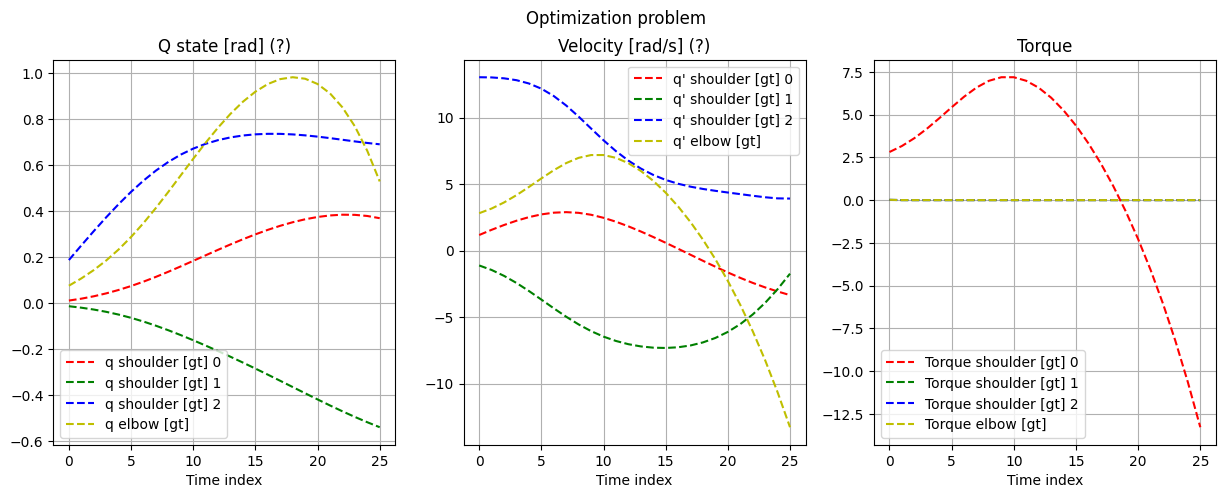

In [16]:
plot_optimization_curves([(gt_tot, "[gt]", "--"),])

# Optimization

In [ ]:
initial_var = initial_optim_var.copy()
initial_var[T * arm_robot.model.nq:] = 0

In [ ]:
sol = least_squares(objective, initial_var, args=(ground_truth_p, T), method="lm").x

In [ ]:
np.linalg.norm(objective(sol, ground_truth_p, T, True))

In [ ]:
np.linalg.norm(objective(initial_optim_var, ground_truth_p, T, True))

In [ ]:
#interactive_replay_sequence(
#    {
#        "estimated": res[:, :arm_robot.model.nq],
#        "groundtruth": gt_sol[:, :arm_robot.model.nq],
#    },
#    viz
#)

In [ ]:
#plot_optimization_curves([
#    (gt_sol, "[gt]", "--"),
#    (res, "[estimation]", "-"),
#    ]
#)
#plot_optimization_curves([
#    (gt_sol, "[gt]", "--"),
#    ]
#)

#plot_optimization_curves([
#    (res, "[estimation]", "-"),
#    ]
#)

In [ ]:
tq, ttauq = process_var(sol, T, 5)

In [ ]:
for t in range(2, T - 2):

    viz.display(tq[t])

    time.sleep(1e-2)

In [ ]:
q = tq[2].copy()
vq = pin.difference(arm_robot.model, tq[1], tq[3]) / (2 * DT)

ttauq = ttauq.reshape(T - 4, 4)

for t in range(2, T - 2):
    # Compute mass and non linear effects
    M = pin.crba(arm_robot.model, arm_robot.data, q)
    b = pin.nle(arm_robot.model, arm_robot.data, q, vq)

    # Compute accelleration
    aq = np.linalg.solve(M, ttauq[t - 2] - b)

    vq += aq * DT
    q = pin.integrate(arm_robot.model, q, vq * DT)
    
    viz.display(q)
    time.sleep(1e-2)

In [ ]:
tq_gt = np.vstack(rec_ground_truth_q)
ttauq_gt = np.vstack(rec_ground_truth_tauq)[2:-2]

In [ ]:
for t in range(2, T-2):
    viz.display(tq_gt[t])
    time.sleep(1e-2)